- [data_source](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/)
- [org notebook](https://github.com/theairbend3r/how-to-train-your-neural-net/blob/master/pytorch/tabular/regression/multiple%20_regression_wine.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from myutil.genutil import create_directory
from myutil.torchutil import Reproducibility 
from myutil.plotutil import PublishQualityPlot

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
%matplotlib inline
import seaborn as sns

In [6]:
DIR_DATA = "data"
DIR_OUTPUT = "output"
SEED = 2020

In [7]:
create_directory(DIR_DATA)
create_directory(DIR_OUTPUT)

Directory: data/ already exists.
Directory: output/ already exists.


In [8]:
rp = Reproducibility(seed=SEED)
rp.seed_everything()

In [9]:
print("We're using cuda?", torch.cuda.is_available())

We're using cuda? False


In [10]:
df = pd.read_csv("data/winequality-red.csv", delimiter=";")

In [11]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [12]:
pqp = PublishQualityPlot()
pqp.set_params()

In [13]:
pqp.preferable_plot_style()

['seaborn-muted',
 'seaborn-deep',
 'seaborn-colorblind',
 'seaborn-bright',
 'seaborn-pastel']

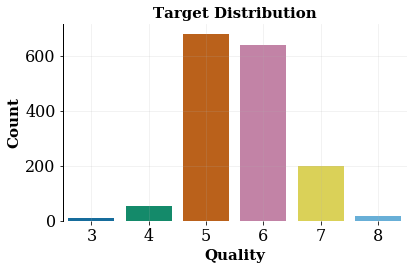

In [14]:
with plt.style.context('seaborn-colorblind'):
    sns.countplot(x = 'quality', data=df)
    plt.title("Target Distribution", fontsize=15, fontweight='bold')
    plt.ylabel("Count", size=15, fontweight='bold')
    plt.xlabel("Quality", size=15, fontweight='bold')
    sns.despine(bottom=True)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [15]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [16]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [18]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [19]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict


In [20]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'rating_3': 7, 'rating_4': 38, 'rating_5': 490, 'rating_6': 459, 'rating_7': 143, 'rating_8': 14}
Test : {'rating_3': 2, 'rating_4': 11, 'rating_5': 136, 'rating_6': 128, 'rating_7': 40, 'rating_8': 3}
Val  : {'rating_3': 1, 'rating_4': 4, 'rating_5': 55, 'rating_6': 51, 'rating_7': 16, 'rating_8': 1}


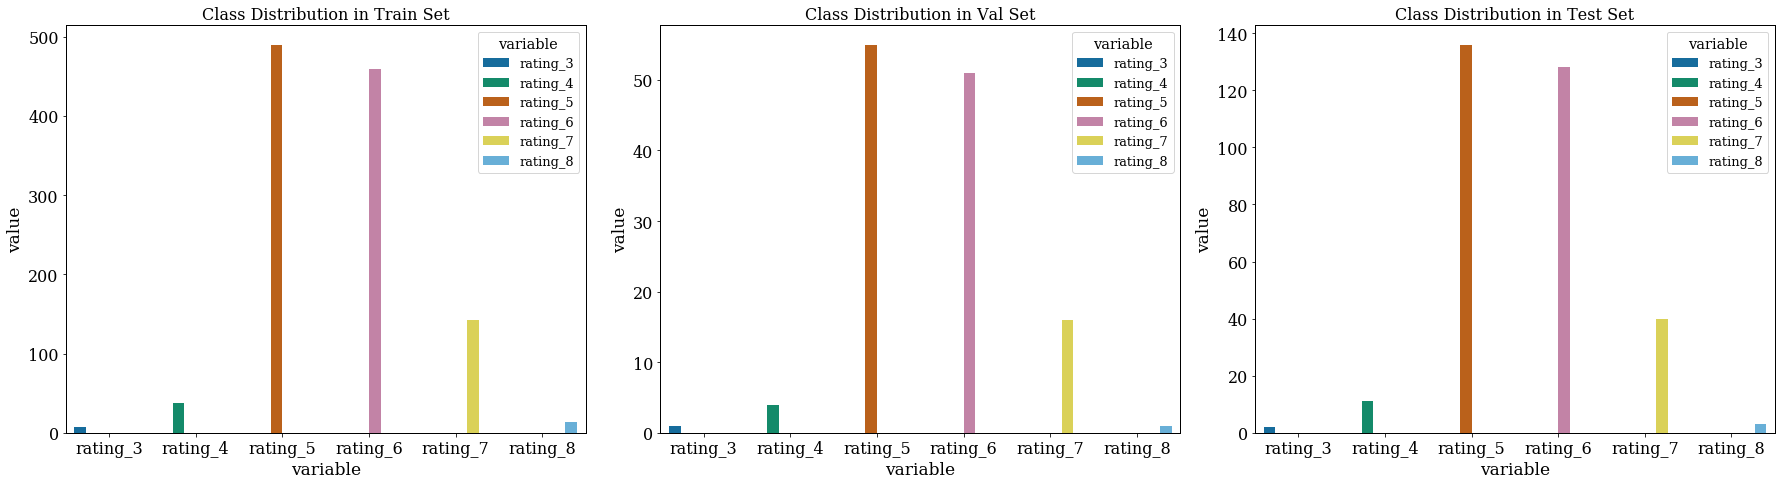

In [40]:
with plt.style.context('seaborn-colorblind'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
    sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
    sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
    sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [22]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [23]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())


In [24]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001

NUM_FEATURES = len(X.columns)

In [25]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)


In [26]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)

        
        return (x)


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [28]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [29]:
loss_stats = {
    'train': [],
    "val": []
}

In [30]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


Epoch 001: | Train Loss: 32.55413 | Val Loss: 31.14209
Epoch 002: | Train Loss: 29.79595 | Val Loss: 27.60742
Epoch 003: | Train Loss: 25.00641 | Val Loss: 20.98050
Epoch 004: | Train Loss: 16.07939 | Val Loss: 9.73178
Epoch 005: | Train Loss: 4.92963 | Val Loss: 1.20624
Epoch 006: | Train Loss: 0.97799 | Val Loss: 1.18851
Epoch 007: | Train Loss: 0.86158 | Val Loss: 0.89877
Epoch 008: | Train Loss: 0.80642 | Val Loss: 0.87568
Epoch 009: | Train Loss: 0.77948 | Val Loss: 0.85101
Epoch 010: | Train Loss: 0.76112 | Val Loss: 0.82755
Epoch 011: | Train Loss: 0.74286 | Val Loss: 0.79635
Epoch 012: | Train Loss: 0.71767 | Val Loss: 0.75460
Epoch 013: | Train Loss: 0.69278 | Val Loss: 0.71166
Epoch 014: | Train Loss: 0.66224 | Val Loss: 0.66894
Epoch 015: | Train Loss: 0.63614 | Val Loss: 0.63906
Epoch 016: | Train Loss: 0.61248 | Val Loss: 0.59652
Epoch 017: | Train Loss: 0.59217 | Val Loss: 0.56843
Epoch 018: | Train Loss: 0.57083 | Val Loss: 0.53850
Epoch 019: | Train Loss: 0.55534 | Val 

In [31]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


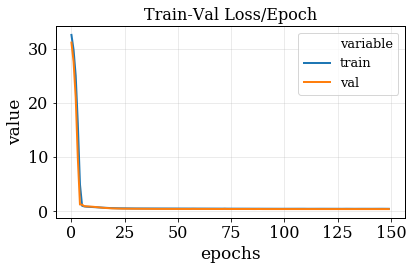

In [36]:
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')
plt.grid(alpha=0.3)
plt.show()

In [33]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

In [34]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [35]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.4137783683461592
R^2 : 0.3587549954802547
